In [1]:
import os
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings,AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ,SSR,MIOSR
from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp
import time
import matplotlib.pyplot as plt
from pysindy import EnsembleOptimizer
plt.style.use('ggplot')
import matplotlib as mpl
# mpl.rcParams.update({"text.usetex":True})

In [10]:
exp_data = LorenzExp
initial_state = jnp.array([ -8,8,27.])
dt = 0.05
t_train = jnp.arange(0,10.01,dt)
noise_var = 0.1
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 505
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=29,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)

lorenz_sol = expdata.system_sol
t_train = expdata.t_train

In [11]:
true_sigma2 = 0.05
x_vals = jax.vmap(lorenz_sol.evaluate)(t_train)
x_train = x_vals + (
    jnp.sqrt(true_sigma2) * 
    jax.random.normal(jax.random.PRNGKey(32),(len(t_train),3))
)

measurement_vecs = jnp.tile(jnp.eye(3),(int(len(t_train)/3+1),1))[:len(t_train)]
y_obs = jnp.sum(measurement_vecs*x_train,axis=1)

In [12]:
n_colloc = 500
trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 1000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100,
)
data_weight =  1.
colloc_weight = 100. * n_colloc
sparsifier = pySindySparsifier(
    STLSQ(threshold = 0.5,alpha = 0.01)
    )


In [13]:
optimizer = AnnealedAlternatingActiveSetLMSolver(
        beta_reg=0.001,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=['x','y','z']
)

model.fit(
    t_train,
    t_colloc = None,
    w_colloc = None,
    partialobs_v = measurement_vecs,
    partialobs_y = y_obs,
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
metrics['model_params'] = model.params


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(1.e-08, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 50000.0}
Solving for data_weight = 1.0, colloc_weight = 400.0 beta_reg = 0.008


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 8.571e+04, gradnorm = 1.141e+06, alpha = 4.167, improvement_ratio = 0.9431
Iteration 1, loss = 2.444e+03, gradnorm = 3.573e+06, alpha = 3.472, improvement_ratio = 0.9721
Iteration 2, loss = 564.9, gradnorm = 9.251e+05, alpha = 3.472, improvement_ratio = 0.7801
Iteration 3, loss = 82.18, gradnorm = 4.549e+05, alpha = 2.894, improvement_ratio = 0.8963
Iteration 4, loss = 47.63, gradnorm = 1.888e+05, alpha = 2.894, improvement_ratio = 0.5554
Iteration 5, loss = 22.13, gradnorm = 1.07e+05, alpha = 2.411, improvement_ratio = 0.8234
Line Search Failed!
Final Iteration Results
Iteration 70, loss = 4.056, gradnorm = 5.765e-05, alpha = 1.875e+03, improvement_ratio = -inf
Solving for data_weight = 1.0, colloc_weight = 2000.0 beta_reg = 0.004


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 4.063, gradnorm = 83.1, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 4.063, gradnorm = 92.47, alpha = 3.472, improvement_ratio = 0.9996
Iteration 2, loss = 4.063, gradnorm = 0.9026, alpha = 2.894, improvement_ratio = 0.9995
Iteration 3, loss = 4.063, gradnorm = 0.7439, alpha = 2.411, improvement_ratio = 0.9995
Iteration 4, loss = 4.063, gradnorm = 0.6239, alpha = 2.009, improvement_ratio = 0.9994
Iteration 5, loss = 4.063, gradnorm = 0.4656, alpha = 1.674, improvement_ratio = 0.9994
Line Search Failed!
Final Iteration Results
Iteration 52, loss = 4.063, gradnorm = 0.0002547, alpha = 87.79, improvement_ratio = -inf
Solving for data_weight = 1.0, colloc_weight = 10000.0 beta_reg = 0.002


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 4.064, gradnorm = 83.22, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 4.064, gradnorm = 31.5, alpha = 3.472, improvement_ratio = 0.9994
Iteration 2, loss = 4.064, gradnorm = 0.2815, alpha = 2.894, improvement_ratio = 0.9997
Iteration 3, loss = 4.064, gradnorm = 0.2581, alpha = 2.411, improvement_ratio = 0.9996
Iteration 4, loss = 4.064, gradnorm = 0.2117, alpha = 2.009, improvement_ratio = 0.9994
Iteration 5, loss = 4.064, gradnorm = 0.1569, alpha = 1.674, improvement_ratio = 0.9993
Line Search Failed!
Final Iteration Results
Iteration 58, loss = 4.064, gradnorm = 0.0005839, alpha = 5.375e+03, improvement_ratio = -inf
Solving for data_weight = 1.0, colloc_weight = 50000.0 beta_reg = 0.001


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 4.064, gradnorm = 83.25, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 4.064, gradnorm = 7.116, alpha = 3.472, improvement_ratio = 0.9996
Iteration 2, loss = 4.064, gradnorm = 0.08904, alpha = 2.894, improvement_ratio = 0.9998
Iteration 3, loss = 4.064, gradnorm = 0.06881, alpha = 2.411, improvement_ratio = 0.9999
Iteration 4, loss = 4.064, gradnorm = 0.05338, alpha = 2.009, improvement_ratio = 0.9997
Iteration 5, loss = 4.064, gradnorm = 0.04359, alpha = 1.674, improvement_ratio = 1.0
Line Search Failed!
Final Iteration Results
Iteration 52, loss = 4.064, gradnorm = 0.009989, alpha = 847.0, improvement_ratio = -inf
Model after smooth warm start
(x)' = 0.918 1 + -10.642 x + 10.627 y + -0.384 z + -0.155 x^2 + 0.082 x y + 0.021 x z + 0.017 y^2 + -0.023 y z + 0.020 z^2
(y)' = -3.274 1 + 28.123 x + -1.074 y + 0.358 z + 0.028 x^2 + 0.013 x y + -1.006 x z + -0.019 y^2 + 0.003 y z + -0.010 z^2
(z)' = 1.804 1 + 0.323 x + -0.050 y + -2.818 z + -0.017 x^2 + 1.029

In [14]:
model.print()

(x)' = -10.034 x + 10.072 y
(y)' = 28.042 x + -1.037 y + -1.001 x z
(z)' = -2.662 z + 1.002 x y


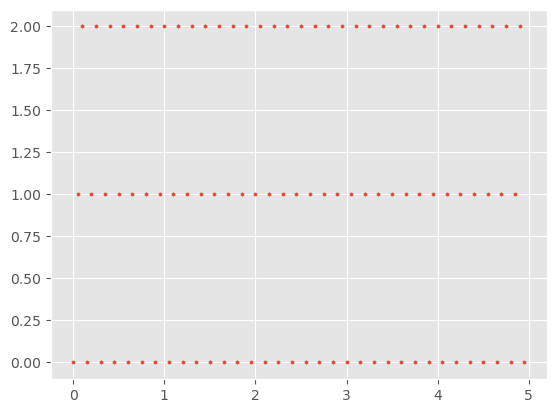

In [16]:
plt.scatter(t_train[:100],jnp.argmax(measurement_vecs,axis=1)[:100],s = 5)

In [40]:
import diffrax
def model_ode(t,x,args = None):
    return model.predict(x)

dt0 = 0.005
stepsize_controller = diffrax.PIDController(rtol = 1e-8,atol =1e-8)
save_at = diffrax.SaveAt(dense=True)  # Save at regular intervals
pred_extend = diffrax.diffeqsolve(
	terms = diffrax.ODETerm(model_ode),
	solver = diffrax.Tsit5(),
	t0=t_train[-1],
	t1=20.,
	dt0=dt0,
	y0=expdata.system_sol.evaluate(t_train[-1]),
	saveat=save_at,
    stepsize_controller=stepsize_controller,
	max_steps = int(10*(t1-t0)/dt0)
)

from data.lorenz import lorenz_system

lorenz_args = (10.0, 28.0, 8.0/3.0)

true_extend = diffrax.diffeqsolve(
	terms = diffrax.ODETerm(lorenz_system),
    solver = diffrax.Tsit5(),
    t0=t_train[-1],
	t1=20.,
    dt0 = dt0,
    y0 = expdata.system_sol.evaluate(t_train[-1]),
    saveat = save_at,
    stepsize_controller=stepsize_controller,
	max_steps = int(10*(t1-t0)/dt),
	args = lorenz_args
)

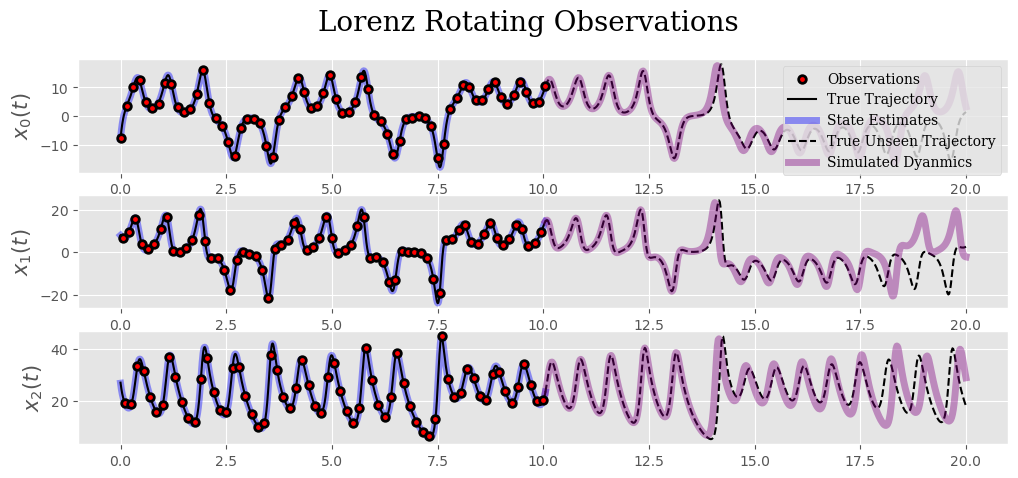

In [ ]:
family='serif'
fig, ax = plt.subplots(3,1, figsize=(12,5))
ylabels = [r"$x_0(t)$", r"$x_1(t)$",r"$x_2(t)$"]

t_fine = jnp.linspace(t_train[0],t_train[-1],1000)
x_true = jax.vmap(expdata.system_sol.evaluate)(t_fine)
x_pred = model.predict_state(t_fine)

t_extend = jnp.linspace(t_train[-1],20,500)

x_true_extend = jax.vmap(true_extend.evaluate)(t_extend)
x_sim_extend = jax.vmap(pred_extend.evaluate)(t_extend)

for dim in range(3):
    obs_index = jnp.where(jnp.argmax(measurement_vecs,axis=1) == dim)    
    ax[dim].scatter(
        t_train[obs_index], y_obs[obs_index],facecolors='red',edgecolors='black',lw=2, label='Observations',s=30,zorder=3)
    
    ax[dim].plot(t_fine, x_true[:,dim], label='True Trajectory',c='black',zorder=2)
    ax[dim].plot(t_fine, x_pred[:,dim], label='State Estimates', linestyle='-',c='blue', alpha=0.4,lw=5,zorder=1)

    # extension 
    ax[dim].plot(t_extend,x_true_extend[:,dim], c='black', linestyle='--', label='True Unseen Trajectory')    

    ax[dim].plot(t_extend,x_sim_extend[:,dim],c='purple',alpha=0.4, lw=5,linestyle='-',label='Simulated Dyanmics')

    ax[dim].grid(True)
    ax[dim].set_ylabel(ylabels[dim], size=15, family=family)
    if dim==0:
        ax[dim].legend(prop={'family':family})
    if dim == 1:
        ax[dim].set_xlabel(r"$t$",size=15, family=family)
plt.suptitle("Lorenz Rotating Observations", family=family,size=20)
# if savefigs:
#     plt.savefig(f"figures_lv/lv_noise_{noise}_dt_{dt_train}_t1_{t1}_unseen_traj.pdf")
plt.show()
